In [1]:
import numpy as np
import pandas as pd
import openpyxl
from openpyxl import Workbook
from openpyxl import load_workbook
import time
import datetime
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import datetime
import dateutil
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import os
from scipy import integrate

In [191]:
import math

In [ ]:
##(6/11/23) I put in a few comments just now in parts that seemed to need a bit of context. All new comments have (6/1/23) in front of them. If they don't then they were made at the time. I gave up on
## adding extra comments to some of the later work because I seemed to have been alright at putting them in. Unfortunately this was one of those notebooks where I kept it open for ages and kept chipping at it
## so it's long and lots of different lines of thinking are included. Hopefully it's not too tricky to navigate, but if you have any questions I'm happy to answer them.

In [2]:
# dS*/dt = 0 | S* means Sb or substrate in bulk

# dS/dt = -1/Fv dP/dt + k1(S*-S) | S means Sc or substrate in compartment

# dI/dt = 1/Fv dP/dt - k2I | I/P mean Ic/Pc or INhibitor/product in compartment

# dP/dt = kcat*S/Km(1+I/KI)+S

# concentration units are M, time units s

In [3]:
# In this scenario the kcat is scaled down by avogadros number because prior attempts where the values were just plugged in made the integration break

##(6/11/23)Looking back at this - this is before I understood the actual approach used in the paper for determining the diffusivities, and so I thought I was including the diffusivity parameters when
## trying to reproduce the rates of product formation of the wild-type system
timepoints = np.linspace(0,5,100,dtype='f')

nA = 6.022*10**23


Fv = 1*10**-7 #volume fraction used
kcat = 6.44 / 6.022*10**23 #scaling down the kcat value. Obtained from Fig 3 in main paper 
Km  = 1.91*10**-6 #Units are in M. Obtained from Fig 3 in main paper (value for 1.5 enzymes/capsid)
Ki = 1.74 *10**-6 #Units in M. Fitted parameter obtained from Table 1
k1 = 1.02*10**4 #units in s^-1. Fitted paremeter from Table 1
k2 = 6.08*10**2 #units in s^-1. Fitted paremeter from Table 1

Sb0 = 20*10**-6
Sc0 = 0.0
Pc0 = 0.0
Ic0 = 0.0

In [4]:
##(6/11/23) Here the equations used are directly adapted from 'Kinetic Modeling' section in the SI
y0 = [Sb0,Sc0,Pc0,Ic0]
def model(y,t):
    Sb,Sc,Pc,Ic = y
    dpdt = (kcat*Sc)/(Km + Sc + ((Km*Ic)/Ki))
    dsdt = -(1/Fv*dpdt) + ((k1*Sb)-(k1*Sc))
    didt = (1/Fv*dpdt) - (k2*Ic)
    dydt = [0,dsdt,dpdt,didt]
    return dydt

In [5]:
testoutput = scipy.integrate.odeint(model,y0,timepoints)

/home/lachlan/miniconda3/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


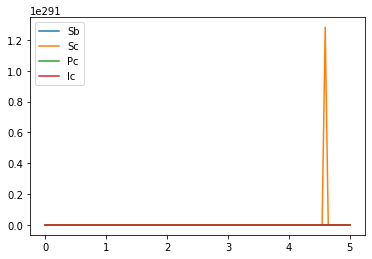

In [6]:
##(6/11/23) Can't quite remember what went wrong here - I think the suspicion was that the scaling down of kcat without corresponding scaling of the diffusivities caused the whole thing to break

fig,ax = plt.subplots()

ax.plot(timepoints,testoutput,label = ['Sb','Sc','Pc','Ic'])
ax.legend()

In [7]:
inhibitor = testoutput[:,3]
product = testoutput[:,2]
compartmentsubstrate = testoutput[:,1]
bulksubstrate = testoutput[:,0]

In [8]:
print(compartmentsubstrate)

[0.00000000e+000 0.00000000e+000 6.90971267e-310 2.12199579e-313
 0.00000000e+000 4.65619197e-310 5.94158821e-313 4.94065646e-324
 4.65619197e-310 6.90971464e-310 8.70018274e-313 6.90971268e-310
 6.90967266e-310 1.16709769e-312 4.65619197e-310 1.18831764e-312
 0.00000000e+000 4.94065646e-324 7.42698527e-313 3.18299369e-313
 4.65619197e-310 4.65619197e-310 4.65619197e-310 4.65619197e-310
 4.65619197e-310 4.65619197e-310 4.65619197e-310 6.90971464e-310
 8.70018274e-313 2.54639495e-313 4.65619197e-310 4.65619197e-310
 4.65619197e-310 4.65619197e-310 4.65619197e-310 4.65619197e-310
 6.90971464e-310 8.70018274e-313 7.21478569e-313 4.65619197e-310
 4.65619197e-310 4.65619197e-310 4.65619197e-310 4.65619197e-310
 4.65619197e-310 4.65619197e-310 6.90967563e-310 9.33678148e-313
 0.00000000e+000 4.65619197e-310 4.65619197e-310 4.65619197e-310
 4.65619197e-310 4.65619197e-310 4.65619197e-310 6.90967266e-310
 1.16709769e-312 0.00000000e+000 4.65619197e-310 4.65619197e-310
 4.65619197e-310 4.656191

In [9]:
## (6/11/23) Here I've tried a model that doesn't include the production of inhibitor to try and reproduce the rates of product formation - I think I hadn't realised the scaling issue yet

no_iy0 = [Sb0,Sc0,Pc0]
def model_noi(y,t):
    Sb,Sc,Pc = y
    dpdt = (kcat*Sc)/(Km + Sc)
    dsdt = -(1/Fv*dpdt) + ((k1*Sb)-(k1*Sc))
    dydt = [0,dsdt,dpdt]
    return dydt

In [10]:
noinhibitor = scipy.integrate.odeint(model_noi,no_iy0,timepoints)

/home/lachlan/miniconda3/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


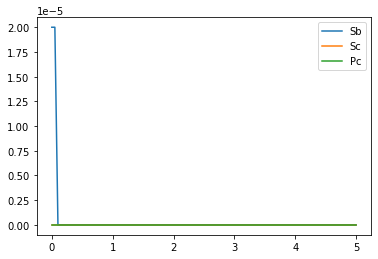

In [11]:
fig,ax = plt.subplots()

ax.plot(timepoints,noinhibitor,label = ['Sb','Sc','Pc'])
ax.legend()

In [12]:
noinhibitor[:,1] ##(6/11/23) here i was looking at the substrate in the compartment

array([0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       6.90967226e-310, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 6.90971569e-310, 0.00000000e+000, 0.00000000e+000,
       6.90967266e-310, 6.90967266e-310, 0.00000000e+000, 6.90967266e-310,
       1.97626258e-323, 4.94065646e-324, 6.90967266e-310, 4.58492919e-321,
       4.65619057e-310, 0.00000000e+000, 5.13828272e-321, 6.90971569e-310,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0

In [13]:
##(6/11/23) I think I thought I needed to scale the kcat by the concentration of the enzyme in M

timepoints = np.linspace(0,0.5,100,dtype='f')

nA = 6.022*10**23


Fv = 1*10**-7
kcat = 6.44 * 2*10**-9 #scaling down the kcat value so the integration doesn't break.
Km  = 1.91*10**-6
Ki = 1.74 *10**-6
k1 = 1.02*10**4
k2 = 6.08*10**2

Sb0 = 20*10**-6
Sc0 = 0.0
Pc0 = 0.0
Ic0 = 0.0

In [14]:
timepoints = np.linspace(0,5,100,dtype='f')

nA = 6.022*10**23


# Fv = 1*10**-7
kcat = 11.6 #/ 6.022*10**23 #scaling down the kcat value so the integration doesn't break.
Km  = 2.13*10**-6 * nA
# Ki = 1.74 *10**-6
# k1 = 1.02*10**4
# k2 = 6.08*10**2

S0 = 20*10**-6 * nA
P0 = 0.0
I0 = 0.0

In [15]:
### This time I tried replicating results from a simpler model system using the same strategy - the Free Alkaline Phosphatase (medium salt) conditions outlined in Supplementary Table S3 and Main Figure 
### 4. What I did this time was scale up all of the concentrations by nA so that the quantities are dealt with in scale of per particle.

In [16]:
timepoints = np.linspace(0,5,100,dtype='f')

nA = 6.022*10**23


# Fv = 1*10**-7
kcat = 11.6 / nA
Km  = 2.13*10**-6 
# Ki = 1.74 *10**-6
# k1 = 1.02*10**4
# k2 = 6.08*10**2

S0 = 20*10**-6 
P0 = 0.0
I0 = 0.0

In [17]:
def MM(y,t):
    S,P = y
    dsdt = -(kcat*S/(Km+S))
    dpdt = (kcat*S/(Km+S))
    dydt = [dsdt,dpdt]
    return dydt

In [18]:
y0  = [S0,P0]

In [19]:
testMM = scipy.integrate.odeint(MM,y0,timepoints)

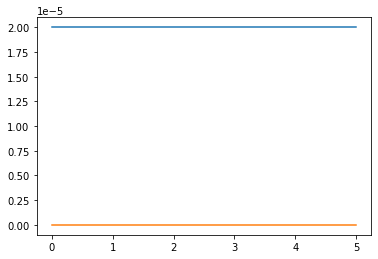

In [20]:
plt.plot(timepoints,testMM)

In [21]:
testMM[:,1]

array([0.00000000e+00, 8.79226200e-25, 1.75845240e-24, 2.63767873e-24,
       3.51690480e-24, 4.39613087e-24, 5.27535746e-24, 6.15458353e-24,
       7.03380960e-24, 7.91303619e-24, 8.79226174e-24, 9.67148885e-24,
       1.05507149e-23, 1.14299410e-23, 1.23091671e-23, 1.31883931e-23,
       1.40676192e-23, 1.49468453e-23, 1.58260724e-23, 1.67052984e-23,
       1.75845235e-23, 1.84637496e-23, 1.93429777e-23, 2.02222038e-23,
       2.11014298e-23, 2.19806559e-23, 2.28598820e-23, 2.37391080e-23,
       2.46183341e-23, 2.54975602e-23, 2.63767863e-23, 2.72560123e-23,
       2.81352384e-23, 2.90144645e-23, 2.98936905e-23, 3.07729166e-23,
       3.16521448e-23, 3.25313708e-23, 3.34105969e-23, 3.42898230e-23,
       3.51690470e-23, 3.60482751e-23, 3.69274991e-23, 3.78067272e-23,
       3.86859554e-23, 3.95651794e-23, 4.04444075e-23, 4.13236315e-23,
       4.22028597e-23, 4.30820837e-23, 4.39613118e-23, 4.48405358e-23,
       4.57197640e-23, 4.65989880e-23, 4.74782161e-23, 4.83574401e-23,
      

In [22]:
v20 = scipy.stats.linregress(timepoints,testMM[:,1])

In [23]:
v20.slope #in M/s/enzyme

1.7408679096963796e-23

In [24]:
v20.slope * nA #scaled by nA so it becomes M/s/M enzyme (which is the same as per molecule per enzyme)

10.483506552191598

In [ ]:
## I did a similar thing as the series of stuff above this (above the last comment like this), except instead of scaling up the concentrations I scaled down the kcat in the integration, then rescaled
## the rates back up to get the same value for initial rate

In [25]:
timepoints = np.linspace(0,5,100,dtype='f')

nA = 6.022*10**23


Fv = 1*10**-7
kcat = 6.44  #scaling down the kcat value so the integration doesn't break.
Km  = 1.91*10**-6 * nA
Ki = 1.74 *10**-6 * nA
k1 = 1.02*10**4
k2 = 6.08*10**2

Sb0 = 20*10**-6 *nA
Sc0 = 0.0
Pc0 = 0.0
Ic0 = 0.0

In [26]:
y0 = [Sb0,Sc0,Pc0,Ic0]
def nanoreactor(y,t):
    Sb,Sc,Pc,Ic = y
    dpdt = (kcat*Sc)/(Km + Sc + ((Km*Ic)/Ki))
    dsdt = -(1/Fv*dpdt) + ((k1*Sb)-(k1*Sc))
    didt = (1/Fv*dpdt) - (k2*Ic)
    dydt = [0,dsdt,dpdt,didt]
    return dydt

In [27]:
testoutput = scipy.integrate.odeint(nanoreactor,y0,timepoints)

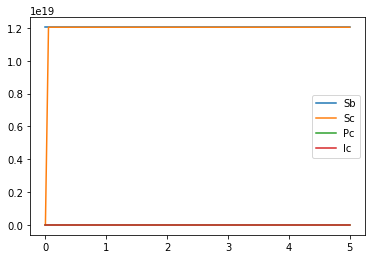

In [28]:
fig,ax = plt.subplots()

ax.plot(timepoints,testoutput,label = ['Sb','Sc','Pc','Ic'])
ax.legend()

In [29]:
testoutput[:,0] / nA # concentration of substrate in bulk -> fixed at 20 uM

array([2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05,
       2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05,
       2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05,
       2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05,
       2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05,
       2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05,
       2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05,
       2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05,
       2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05,
       2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05,
       2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05,
       2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05,
       2.e-05, 2.e-05, 2.e-05, 2.e-05])

In [30]:
testoutput[:,1] / nA # concentration of substrate in compartment -> equilibrates to 20 uM

array([0.e+00, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05,
       2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05,
       2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05,
       2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05,
       2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05,
       2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05,
       2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05,
       2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05,
       2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05,
       2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05,
       2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05,
       2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05,
       2.e-05, 2.e-05, 2.e-05, 2.e-05])

In [31]:
scaledproduct = testoutput[:,2] / nA #Concentration of product in bulk

In [32]:
scaledproduct/0.000000002

array([0.00000000e+00, 2.46400204e-16, 4.92911906e-16, 7.39423644e-16,
       9.85935309e-16, 1.23244697e-15, 1.47895879e-15, 1.72547045e-15,
       1.97198212e-15, 2.21849393e-15, 2.46500545e-15, 2.71151740e-15,
       2.95802907e-15, 3.20454074e-15, 3.45105240e-15, 3.69756407e-15,
       3.94407573e-15, 4.19058740e-15, 4.43709935e-15, 4.68361102e-15,
       4.93012239e-15, 5.17663406e-15, 5.42314631e-15, 5.66965797e-15,
       5.91616964e-15, 6.16268130e-15, 6.40919297e-15, 6.65570463e-15,
       6.90221630e-15, 7.14872796e-15, 7.39523963e-15, 7.64175130e-15,
       7.88826296e-15, 8.13477463e-15, 8.38128629e-15, 8.62779796e-15,
       8.87431020e-15, 9.12082187e-15, 9.36733354e-15, 9.61384520e-15,
       9.86035628e-15, 1.01068685e-14, 1.03533796e-14, 1.05998919e-14,
       1.08464041e-14, 1.10929152e-14, 1.13394274e-14, 1.15859385e-14,
       1.18324508e-14, 1.20789619e-14, 1.23254741e-14, 1.25719852e-14,
       1.28184974e-14, 1.30650085e-14, 1.33115208e-14, 1.35580318e-14,
      

In [33]:
testoutput[:,3]

array([    0.        , 96687.40541733, 96687.40541478, 96687.4054145 ,
       96687.4054145 , 96687.40541449, 96687.40541449, 96687.40541449,
       96687.40541449, 96687.40541449, 96687.40541449, 96687.40541449,
       96687.40541449, 96687.40541449, 96687.40541449, 96687.40541449,
       96687.40541449, 96687.40541449, 96687.40541449, 96687.40541449,
       96687.40541449, 96687.40541449, 96687.40541449, 96687.40541449,
       96687.40541449, 96687.40541449, 96687.40541449, 96687.40541449,
       96687.40541449, 96687.40541449, 96687.40541449, 96687.40541449,
       96687.40541449, 96687.40541449, 96687.40541449, 96687.40541449,
       96687.40541449, 96687.40541449, 96687.40541449, 96687.40541449,
       96687.40541449, 96687.40541449, 96687.40541449, 96687.40541449,
       96687.40541449, 96687.40541449, 96687.40541449, 96687.40541449,
       96687.40541449, 96687.40541449, 96687.40541449, 96687.40541449,
       96687.40541449, 96687.40541449, 96687.40541449, 96687.40541449,
      

In [ ]:
### I tried again the more complicated system, this time with the concentrations scaled up, but the results seem confusing. The main issue seems to be the product/inhibitor concentrations are off
### compared to what was shown in the results of the main paper. 

In [25]:
timepoints = np.linspace(0,5,100,dtype='f')

nA = 6.022*10**23


Fv = 1*10**-7
kcat = 6.44  #scaling down the kcat value so the integration doesn't break.
Km  = 1.91*10**-6 * nA
Ki = 1.74 *10**-6 * nA
k1 = 1.02*10**4
k2 = 6.08*10**2

Sb0 = 20*10**-6 *nA
Sc0 = 0.0
Pc0 = 0.0
Ic0 = 0.0

In [34]:
y0 = [Sb0,Sc0,Pc0,Ic0]
def nanoreactor(y,t):
    Sb,Sc,Pc,Ic = y
    dpdt = (kcat*Sc)/(Km + Sc + ((Km*Ic)/Ki))
    dsdt = -(dpdt) + ((k1*Sb)-(k1*Sc))
    didt = (dpdt) - (k2*Ic)
    dydt = [0,dsdt,dpdt,didt]
    return dydt

In [35]:
testoutput = scipy.integrate.odeint(nanoreactor,y0,timepoints)

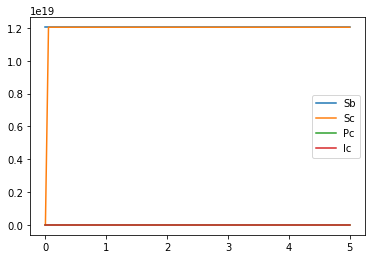

In [36]:
fig,ax = plt.subplots()

ax.plot(timepoints,testoutput,label = ['Sb','Sc','Pc','Ic'])
ax.legend()

In [40]:
testoutput[:,1] / nA

array([0.e+00, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05,
       2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05,
       2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05,
       2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05,
       2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05,
       2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05,
       2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05,
       2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05,
       2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05,
       2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05,
       2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05,
       2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05,
       2.e-05, 2.e-05, 2.e-05, 2.e-05])

In [41]:
testoutput[:,2] #not sure why we're getting fractional numbers of product molecules, which are also quite small

array([ 0.        ,  0.2967644 ,  0.59366309,  0.89056183,  1.18746048,
        1.48435913,  1.78125795,  2.0781566 ,  2.37505525,  2.67195408,
        2.96885255,  3.26575155,  3.5626502 ,  3.85954885,  4.1564475 ,
        4.45334615,  4.7502448 ,  5.04714345,  5.34404245,  5.6409411 ,
        5.9378394 ,  6.23473805,  6.5316374 ,  6.82853605,  7.1254347 ,
        7.42233335,  7.719232  ,  8.01613065,  8.3130293 ,  8.60992795,
        8.9068266 ,  9.20372525,  9.5006239 ,  9.79752255, 10.0944212 ,
       10.39131985, 10.6882192 , 10.98511785, 11.2820165 , 11.57891515,
       11.8758131 , 12.17271245, 12.4696104 , 12.76650975, 13.0634091 ,
       13.36030705, 13.6572064 , 13.95410435, 14.2510037 , 14.54790165,
       14.844801  , 15.14169895, 15.4385983 , 15.73549625, 16.0323956 ,
       16.32929355, 16.6261929 , 16.92309225, 17.2199902 , 17.51688955,
       17.8137875 , 18.11068685, 18.4075848 , 18.70448415, 19.0013821 ,
       19.29828145, 19.5951794 , 19.89207875, 20.1889767 , 20.48

In [42]:
testoutput[:,3] # inhibitor remains constant, but the numbers are off, same thing with product being produced, but numbers are off

array([0.        , 0.00966874, 0.00966874, 0.00966874, 0.00966874,
       0.00966874, 0.00966874, 0.00966874, 0.00966874, 0.00966874,
       0.00966874, 0.00966874, 0.00966874, 0.00966874, 0.00966874,
       0.00966874, 0.00966874, 0.00966874, 0.00966874, 0.00966874,
       0.00966874, 0.00966874, 0.00966874, 0.00966874, 0.00966874,
       0.00966874, 0.00966874, 0.00966874, 0.00966874, 0.00966874,
       0.00966874, 0.00966874, 0.00966874, 0.00966874, 0.00966874,
       0.00966874, 0.00966874, 0.00966874, 0.00966874, 0.00966874,
       0.00966874, 0.00966874, 0.00966874, 0.00966874, 0.00966874,
       0.00966874, 0.00966874, 0.00966874, 0.00966874, 0.00966874,
       0.00966874, 0.00966874, 0.00966874, 0.00966874, 0.00966874,
       0.00966874, 0.00966874, 0.00966874, 0.00966874, 0.00966874,
       0.00966874, 0.00966874, 0.00966874, 0.00966874, 0.00966874,
       0.00966874, 0.00966874, 0.00966874, 0.00966874, 0.00966874,
       0.00966874, 0.00966874, 0.00966874, 0.00966874, 0.00966

In [43]:
timepoints = np.linspace(0,5,100,dtype='f')

nA = 6.022*10**23


Fv = 1*10**-7
kcat = 6.44  #scaling down the kcat value so the integration doesn't break.
Km  = 7.14*10**-7 * nA
Ki = 1.74 *10**-6 * nA
k1 = 1.02*10**4
k2 = 6.08*10**2

Sb0 = 20*10**-6 *nA
Sc0 = 0.0
Pc0 = 0.0
Ic0 = 0.0

In [44]:
### my bright idea - is the Km value being used wrong because it's the apparent Km from fitting data without inclusion of Ki in the model???? I can't seem to see the real Km in the paper, 
### but it should be able to be determined from the paper's data

In [45]:
y0 = [Sb0,Sc0,Pc0,Ic0]
def nanoreactor(y,t):
    Sb,Sc,Pc,Ic = y
    dpdt = (kcat*Sc)/(Km + Sc + ((Km*Ic)/Ki))
    dsdt = -(1/Fv*dpdt) + ((k1*Sb)-(k1*Sc))
    didt = (1/Fv*dpdt) - (k2*Ic)
    dydt = [0,dsdt,dpdt,didt]
    return dydt

In [46]:
testoutput = scipy.integrate.odeint(nanoreactor,y0,timepoints)

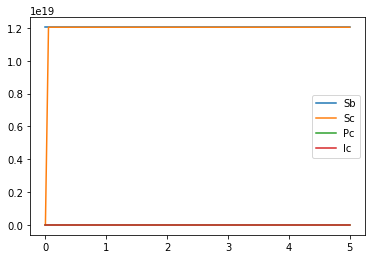

In [47]:
fig,ax = plt.subplots()

ax.plot(timepoints,testoutput,label = ['Sb','Sc','Pc','Ic'])
ax.legend()

In [49]:
testoutput[:,3]

array([     0.        , 102270.01293471, 102270.01319765, 102270.01316145,
       102270.01316152, 102270.01316158, 102270.01316165, 102270.0131617 ,
       102270.0131617 , 102270.0131617 , 102270.01316171, 102270.01316171,
       102270.01316171, 102270.01316171, 102270.01316171, 102270.01316171,
       102270.01316171, 102270.01316171, 102270.01316171, 102270.01316171,
       102270.01316171, 102270.01316171, 102270.01316171, 102270.01316171,
       102270.01316171, 102270.01316171, 102270.01316171, 102270.01316171,
       102270.01316171, 102270.01316171, 102270.01316171, 102270.01316171,
       102270.01316171, 102270.01316171, 102270.01316171, 102270.01316171,
       102270.01316171, 102270.01316171, 102270.01316171, 102270.01316171,
       102270.01316171, 102270.01316171, 102270.01316171, 102270.01316171,
       102270.01316171, 102270.01316171, 102270.01316171, 102270.01316171,
       102270.01316171, 102270.01316171, 102270.01316171, 102270.01316171,
       102270.01316171, 1

In [51]:
testoutput[:,2] / nA #M of product produced from 1 enzyme

array([0.00000000e+00, 5.21368242e-25, 1.04285819e-24, 1.56434821e-24,
       2.08583808e-24, 2.60732796e-24, 3.12881813e-24, 3.65030800e-24,
       4.17179788e-24, 4.69328805e-24, 5.21477762e-24, 5.73626810e-24,
       6.25775797e-24, 6.77924784e-24, 7.30073771e-24, 7.82222759e-24,
       8.34371746e-24, 8.86520733e-24, 9.38669781e-24, 9.90818768e-24,
       1.04296769e-23, 1.09511668e-23, 1.14726579e-23, 1.19941478e-23,
       1.25156377e-23, 1.30371275e-23, 1.35586174e-23, 1.40801073e-23,
       1.46015971e-23, 1.51230870e-23, 1.56445769e-23, 1.61660667e-23,
       1.66875566e-23, 1.72090465e-23, 1.77305364e-23, 1.82520262e-23,
       1.87735173e-23, 1.92950072e-23, 1.98164971e-23, 2.03379869e-23,
       2.08594756e-23, 2.13809667e-23, 2.19024553e-23, 2.24239464e-23,
       2.29454375e-23, 2.34669262e-23, 2.39884173e-23, 2.45099059e-23,
       2.50313970e-23, 2.55528857e-23, 2.60743768e-23, 2.65958654e-23,
       2.71173565e-23, 2.76388451e-23, 2.81603362e-23, 2.86818249e-23,
      

In [54]:
(testoutput[:,2]/nA)*(1.2044*10**15)

array([0.00000000e+00, 6.27935911e-10, 1.25601840e-09, 1.88410099e-09,
       2.51218339e-09, 3.14026579e-09, 3.76834856e-09, 4.39643096e-09,
       5.02451336e-09, 5.65259613e-09, 6.28067816e-09, 6.90876130e-09,
       7.53684370e-09, 8.16492610e-09, 8.79300850e-09, 9.42109090e-09,
       1.00491733e-08, 1.06772557e-08, 1.13053388e-08, 1.19334212e-08,
       1.25615029e-08, 1.31895853e-08, 1.38176692e-08, 1.44457516e-08,
       1.50738340e-08, 1.57019164e-08, 1.63299988e-08, 1.69580812e-08,
       1.75861636e-08, 1.82142460e-08, 1.88423284e-08, 1.94704108e-08,
       2.00984932e-08, 2.07265756e-08, 2.13546580e-08, 2.19827404e-08,
       2.26108243e-08, 2.32389067e-08, 2.38669891e-08, 2.44950715e-08,
       2.51231524e-08, 2.57512363e-08, 2.63793172e-08, 2.70074011e-08,
       2.76354850e-08, 2.82635659e-08, 2.88916498e-08, 2.95197307e-08,
       3.01478146e-08, 3.07758955e-08, 3.14039794e-08, 3.20320603e-08,
       3.26601442e-08, 3.32882251e-08, 3.39163090e-08, 3.45443899e-08,
      

In [ ]:
### rescaled the Km of the enzyme to be the true one but still getting numbers that are off.

In [82]:
timepoints = np.linspace(0,5,100,dtype='f')

nA = 6.022*10**23


Fv = 1*10**-7
kcat = 6.44  #scaling down the kcat value so the integration doesn't break.
Km  = 7.14*10**-7 * nA
Ki = 1.74 *10**-6 * nA
k1 = 1.02*10**4
k2 = 6.08*10**2

Sb0 = 20*10**-6 *nA
Sc0 = 0.0
Pc0 = 0.0
Ic0 = 0.0

In [83]:
S0 = Sb0
P0 = Pc0
I0 = Ic0
y0 = [S0,P0,I0]
def MM_product_inhibition(y,t):
    S,P,I = y
    dpdt = (kcat*S)/(Km + S + ((Km*I)/Ki))
    dsdt = -(dpdt)
    didt = (dpdt)
    dydt = [dsdt,dpdt,didt]
    return dydt

In [84]:
testoutput = scipy.integrate.odeint(MM_product_inhibition,y0,timepoints)

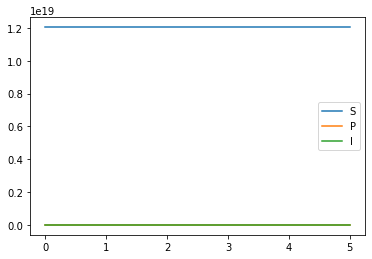

In [85]:
fig,ax = plt.subplots()

ax.plot(timepoints,testoutput,label = ['S','P','I'])
ax.legend()

In [86]:
testoutput[:,1]

array([ 0.        ,  0.31404125,  0.62808249,  0.94212379,  1.25616499,
        1.57020619,  1.88424757,  2.19828877,  2.51232997,  2.82637136,
        3.14041237,  3.45445394,  3.76849514,  4.08253634,  4.39657754,
        4.71061874,  5.02465994,  5.33870114,  5.65274271,  5.96678391,
        6.28082474,  6.59486594,  6.90890789,  7.22294909,  7.53699029,
        7.85103149,  8.16507269,  8.47911389,  8.79315509,  9.10719629,
        9.42123749,  9.73527869, 10.04931989, 10.36336109, 10.67740229,
       10.99144349, 11.30548543, 11.61952663, 11.93356783, 12.24760903,
       12.56164949, 12.87569143, 13.18973189, 13.50377383, 13.81781577,
       14.13185623, 14.44589817, 14.75993863, 15.07398057, 15.38802103,
       15.70206297, 16.01610343, 16.33014537, 16.64418583, 16.95822777,
       17.27226823, 17.58631017, 17.90035211, 18.21439257, 18.52843451,
       18.84247497, 19.15651691, 19.47055737, 19.78459931, 20.09863977,
       20.41268171, 20.72672217, 21.04076411, 21.35480457, 21.66

In [87]:
testoutput[:,2]

array([ 0.        ,  0.31404125,  0.62808249,  0.94212379,  1.25616499,
        1.57020619,  1.88424757,  2.19828877,  2.51232997,  2.82637136,
        3.14041237,  3.45445394,  3.76849514,  4.08253634,  4.39657754,
        4.71061874,  5.02465994,  5.33870114,  5.65274271,  5.96678391,
        6.28082474,  6.59486594,  6.90890789,  7.22294909,  7.53699029,
        7.85103149,  8.16507269,  8.47911389,  8.79315509,  9.10719629,
        9.42123749,  9.73527869, 10.04931989, 10.36336109, 10.67740229,
       10.99144349, 11.30548543, 11.61952663, 11.93356783, 12.24760903,
       12.56164949, 12.87569143, 13.18973189, 13.50377383, 13.81781577,
       14.13185623, 14.44589817, 14.75993863, 15.07398057, 15.38802103,
       15.70206297, 16.01610343, 16.33014537, 16.64418583, 16.95822777,
       17.27226823, 17.58631017, 17.90035211, 18.21439257, 18.52843451,
       18.84247497, 19.15651691, 19.47055737, 19.78459931, 20.09863977,
       20.41268171, 20.72672217, 21.04076411, 21.35480457, 21.66

In [89]:
v20 = scipy.stats.linregress(timepoints,testoutput[:,1])
v20.slope

6.218016800231723

In [ ]:
## when removing the compartment stuff, the system behaves as expected - equal amounts of substrate and product being produced

In [90]:
timepoints = np.linspace(0,5,100,dtype='f')

nA = 6.022*10**23


Fv = 1*10**-7
kcat = 11.66  
Km  = 7.14*10**-7 * nA
Ki = 1.74 *10**-6 * nA
k1 = 1.02*10**4
k2 = 6.08*10**2

Sb0 = 20*10**-6 *nA
Sc0 = 0.0
Pc0 = 0.0
Ic0 = 0.0

In [91]:
S0 = Sb0
P0 = Pc0
I0 = Ic0
y0 = [S0,P0,I0]
def MM_product_inhibition(y,t):
    S,P,I = y
    dpdt = (kcat*S)/(Km + S + ((Km*I)/Ki))
    dsdt = -(dpdt)
    didt = (dpdt)
    dydt = [dsdt,dpdt,didt]
    return dydt

In [92]:
testoutput = scipy.integrate.odeint(MM_product_inhibition,y0,timepoints)

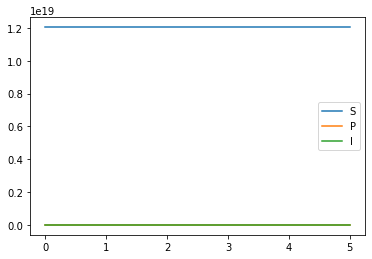

In [93]:
fig,ax = plt.subplots()

ax.plot(timepoints,testoutput,label = ['S','P','I'])
ax.legend()

In [94]:
testoutput[:,1]

array([ 0.        ,  0.56859021,  1.13718041,  1.70577071,  2.27436083,
        2.84295095,  3.41154141,  3.98013153,  4.54872166,  5.11731212,
        5.6859019 ,  6.2544927 ,  6.82308282,  7.39167294,  7.96026307,
        8.52885319,  9.09744331,  9.66603344, 10.23462423, 10.80321435,
       11.37180381, 11.94039393, 12.50898539, 13.07757552, 13.64616564,
       14.21475576, 14.78334589, 15.35193601, 15.92052613, 16.48911626,
       17.05770638, 17.6262965 , 18.19488663, 18.76347675, 19.33206687,
       19.900657  , 20.46924846, 21.03783858, 21.60642871, 22.17501883,
       22.74360761, 23.31219908, 23.88078786, 24.44937932, 25.01797079,
       25.58655957, 26.15515104, 26.72373982, 27.29233128, 27.86092006,
       28.42951153, 28.99810031, 29.56669178, 30.13528056, 30.70387202,
       31.2724608 , 31.84105227, 32.40964373, 32.97823251, 33.54682398,
       34.11541276, 34.68400423, 35.25259301, 35.82118447, 36.38977325,
       36.95836472, 37.5269535 , 38.09554497, 38.66413375, 39.23

In [95]:
v20 = scipy.stats.linregress(timepoints,testoutput[:,1])

In [97]:
v20.slope #slope is in

11.258086318431978

In [98]:
timepoints = np.linspace(0,5,100,dtype='f')

nA = 6.022*10**23


Fv = 1*10**-7
kcat = 11.66 / nA
Km  = 7.14*10**-7
Ki = 1.74 *10**-6
k1 = 1.02*10**4
k2 = 6.08*10**2

Sb0 = 20*10**-6
Sc0 = 0.0
Pc0 = 0.0
Ic0 = 0.0

In [99]:
S0 = Sb0
P0 = Pc0
I0 = Ic0
y0 = [S0,P0,I0]
def MM_product_inhibition(y,t):
    S,P,I = y
    dpdt = (kcat*S)/(Km + S + ((Km*I)/Ki))
    dsdt = -(dpdt)
    didt = (dpdt)
    dydt = [dsdt,dpdt,didt]
    return dydt

In [100]:
testoutput = scipy.integrate.odeint(MM_product_inhibition,y0,timepoints)

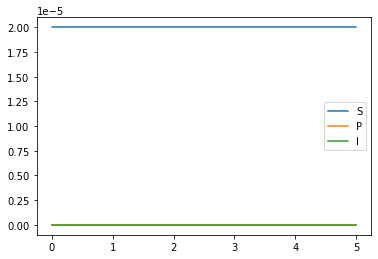

In [101]:
fig,ax = plt.subplots()

ax.plot(timepoints,testoutput,label = ['S','P','I'])
ax.legend()

In [102]:
testoutput[:,1]

array([0.00000000e+00, 9.44188321e-25, 1.88837664e-24, 2.83256510e-24,
       3.77675329e-24, 4.72094147e-24, 5.66513021e-24, 6.60931839e-24,
       7.55350657e-24, 8.49769531e-24, 9.44188293e-24, 1.03860722e-23,
       1.13302604e-23, 1.22744486e-23, 1.32186368e-23, 1.41628250e-23,
       1.51070131e-23, 1.60512013e-23, 1.69953906e-23, 1.79395788e-23,
       1.88837659e-23, 1.98279541e-23, 2.07721445e-23, 2.17163326e-23,
       2.26605208e-23, 2.36047090e-23, 2.45488972e-23, 2.54930854e-23,
       2.64372736e-23, 2.73814617e-23, 2.83256499e-23, 2.92698381e-23,
       3.02140263e-23, 3.11582145e-23, 3.21024026e-23, 3.30465908e-23,
       3.39907812e-23, 3.49349694e-23, 3.58791576e-23, 3.68233458e-23,
       3.77675317e-23, 3.87117221e-23, 3.96559081e-23, 4.06000985e-23,
       4.15442889e-23, 4.24884749e-23, 4.34326653e-23, 4.43768512e-23,
       4.53210417e-23, 4.62652276e-23, 4.72094180e-23, 4.81536040e-23,
       4.90977944e-23, 5.00419803e-23, 5.09861707e-23, 5.19303567e-23,
      

In [105]:
v20 = scipy.stats.linregress(timepoints,testoutput[:,1])

In [106]:
v20.slope * nA #slope is in

11.258086318431985

In [ ]:
### Okay I must have confused myself at one point - I thought that by scaling up the concentrations of substrates and products (to molecules instead of mol) that I didn't need to re-scale the slope??? 
### Compared to scaling down the kcat (by dividing by nA to get mol per second instead of molecules), in both instances I still need to multiply the slope by avogadro's number to get the right velocity
### in per s per M of enzyme


### Actually the above is incorrect - because I was copying and pasting code I was getting the slope from a previous output, where the kcat was scaled down instead of concentrations scaled up.
### This is why the initiial slopes needed rescaling. When I used the proper output from scaled down kcat, I needed to rescale the slope, when using the output from scaled up concentrations, I did not.

In [107]:
timepoints = np.linspace(0,5,100,dtype='f')

nA = 6.022*10**23


Fv = 1*10**-7
kcat = 11.66  
Km  = 7.14*10**-7 * nA
Ki = 1.74 *10**-6 * nA
k1 = 1.02*10**4
k2 = 6.08*10**2

Sb0 = 20*10**-6 *nA
Sc0 = 0.0
Pc0 = 0.0
Ic0 = 0.0

In [109]:
y0 = [Sb0,Sc0,Pc0,Ic0]

def nanoreactor_nov(y,t):
    Sb,Sc,Pc,Ic = y
    dpdt = (kcat*Sc)/(Km + Sc + ((Km*Ic)/Ki))
    dsdt = -(dpdt) + (k1*Sb - k1*Sc)
    didt = (dpdt) - (k2*Ic)
    dydt = [0,dsdt,dpdt,didt]
    return dydt

In [110]:
testcompartment = scipy.integrate.odeint(nanoreactor_nov,y0,timepoints)

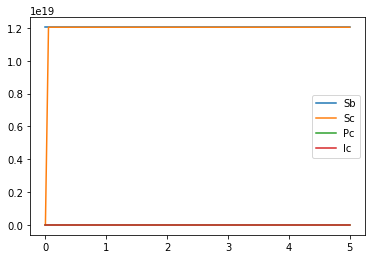

In [111]:
fig,ax = plt.subplots()

ax.plot(timepoints,testcompartment,label = ['Sb','Sc','Pc','Ic'])
ax.legend()

In [112]:
testcompartment[:,0] #Substrate in bulk is at 20 uM

array([1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19,
       1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19,
       1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19,
       1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19,
       1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19,
       1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19,
       1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19,
       1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19,
       1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19,
       1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19,
       1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19,
       1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19,
       1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19,
       1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19,
       1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e

In [113]:
testcompartment[:,1] #Substrate in compartment is at 20 uM

array([0.0000e+00, 1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19,
       1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19,
       1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19,
       1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19,
       1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19,
       1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19,
       1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19,
       1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19,
       1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19,
       1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19,
       1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19,
       1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19,
       1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19,
       1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19,
       1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e

In [114]:
testcompartment[:,2] #number of molecules of product produced overall

array([ 0.        ,  0.56845749,  1.1370477 ,  1.70563799,  2.27422811,
        2.84281823,  3.41140869,  3.97999882,  4.54858894,  5.1171794 ,
        5.68576918,  6.25435998,  6.8229501 ,  7.39154023,  7.96013035,
        8.52872047,  9.0973106 ,  9.66590072, 10.23449151, 10.80308164,
       11.37167109, 11.94026121, 12.50885268, 13.0774428 , 13.64603292,
       14.21462305, 14.78321317, 15.35180329, 15.92039342, 16.48898354,
       17.05757366, 17.62616379, 18.19475391, 18.76334403, 19.33193415,
       19.90052428, 20.46911574, 21.03770587, 21.60629599, 22.17488611,
       22.74347489, 23.31206636, 23.88065514, 24.44924661, 25.01783807,
       25.58642685, 26.15501832, 26.7236071 , 27.29219856, 27.86078735,
       28.42937881, 28.99796759, 29.56655906, 30.13514784, 30.7037393 ,
       31.27232808, 31.84091955, 32.40951101, 32.9780998 , 33.54669126,
       34.11528004, 34.68387151, 35.25246029, 35.82105175, 36.38964054,
       36.958232  , 37.52682078, 38.09541225, 38.66400103, 39.23

In [117]:
testcompartment[:,3] # number of molecules of inhibitor in the reaction mixture - seems off

array([0.        , 0.01851659, 0.01851659, 0.01851659, 0.01851659,
       0.01851659, 0.01851659, 0.01851659, 0.01851659, 0.01851659,
       0.01851659, 0.01851659, 0.01851659, 0.01851659, 0.01851659,
       0.01851659, 0.01851659, 0.01851659, 0.01851659, 0.01851659,
       0.01851659, 0.01851659, 0.01851659, 0.01851659, 0.01851659,
       0.01851659, 0.01851659, 0.01851659, 0.01851659, 0.01851659,
       0.01851659, 0.01851659, 0.01851659, 0.01851659, 0.01851659,
       0.01851659, 0.01851659, 0.01851659, 0.01851659, 0.01851659,
       0.01851659, 0.01851659, 0.01851659, 0.01851659, 0.01851659,
       0.01851659, 0.01851659, 0.01851659, 0.01851659, 0.01851659,
       0.01851659, 0.01851659, 0.01851659, 0.01851659, 0.01851659,
       0.01851659, 0.01851659, 0.01851659, 0.01851659, 0.01851659,
       0.01851659, 0.01851659, 0.01851659, 0.01851659, 0.01851659,
       0.01851659, 0.01851659, 0.01851659, 0.01851659, 0.01851659,
       0.01851659, 0.01851659, 0.01851659, 0.01851659, 0.01851

In [119]:
scipy.stats.linregress(timepoints,testcompartment[:,2]).slope

11.258084757349886

In [ ]:
### Seems to capture the initial rate for the product formation, but the inhibitor is still a meaningless number at the moment. Also this uses kinetic parameters for the wild-type enzyme.
### The comparison graph shown in the results uses the negative mutant.

In [107]:
timepoints = np.linspace(0,5,100,dtype='f')

nA = 6.022*10**23


Fv = 1*10**-7
kcat = 11.66  
Km  = 7.14*10**-7 * nA
Ki = 1.74 *10**-6 * nA
k1 = 1.02*10**4
k2 = 6.08*10**2

Sb0 = 20*10**-6 *nA
Sc0 = 0.0
Pc0 = 0.0
Ic0 = 0.0

In [109]:
y0 = [Sb0,Sc0,Pc0,Ic0]

def nanoreactor_nov(y,t):
    Sb,Sc,Pc,Ic = y
    dpdt = (kcat*Sc)/(Km + Sc + ((Km*Ic)/Ki))
    dsdt = -(dpdt) + (k1*Sb - k1*Sc)
    didt = (dpdt) - (k2*Ic)
    dydt = [0,dsdt,dpdt,didt]
    return dydt

In [110]:
testcompartment = scipy.integrate.odeint(nanoreactor_nov,y0,timepoints)

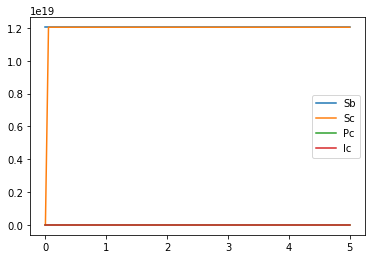

In [111]:
fig,ax = plt.subplots()

ax.plot(timepoints,testcompartment,label = ['Sb','Sc','Pc','Ic'])
ax.legend()

In [112]:
testcompartment[:,0] #Substrate in bulk is at 20 uM

array([1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19,
       1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19,
       1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19,
       1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19,
       1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19,
       1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19,
       1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19,
       1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19,
       1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19,
       1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19,
       1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19,
       1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19,
       1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19,
       1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19,
       1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e

In [113]:
testcompartment[:,1] #Substrate in compartment is at 20 uM

array([0.0000e+00, 1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19,
       1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19,
       1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19,
       1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19,
       1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19,
       1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19,
       1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19,
       1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19,
       1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19,
       1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19,
       1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19,
       1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19,
       1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19,
       1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19,
       1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e+19, 1.2044e

In [114]:
testcompartment[:,2] #number of molecules of product produced overall

array([ 0.        ,  0.56845749,  1.1370477 ,  1.70563799,  2.27422811,
        2.84281823,  3.41140869,  3.97999882,  4.54858894,  5.1171794 ,
        5.68576918,  6.25435998,  6.8229501 ,  7.39154023,  7.96013035,
        8.52872047,  9.0973106 ,  9.66590072, 10.23449151, 10.80308164,
       11.37167109, 11.94026121, 12.50885268, 13.0774428 , 13.64603292,
       14.21462305, 14.78321317, 15.35180329, 15.92039342, 16.48898354,
       17.05757366, 17.62616379, 18.19475391, 18.76334403, 19.33193415,
       19.90052428, 20.46911574, 21.03770587, 21.60629599, 22.17488611,
       22.74347489, 23.31206636, 23.88065514, 24.44924661, 25.01783807,
       25.58642685, 26.15501832, 26.7236071 , 27.29219856, 27.86078735,
       28.42937881, 28.99796759, 29.56655906, 30.13514784, 30.7037393 ,
       31.27232808, 31.84091955, 32.40951101, 32.9780998 , 33.54669126,
       34.11528004, 34.68387151, 35.25246029, 35.82105175, 36.38964054,
       36.958232  , 37.52682078, 38.09541225, 38.66400103, 39.23

In [117]:
testcompartment[:,3] # number of molecules of inhibitor in the reaction mixture - seems off

array([0.        , 0.01851659, 0.01851659, 0.01851659, 0.01851659,
       0.01851659, 0.01851659, 0.01851659, 0.01851659, 0.01851659,
       0.01851659, 0.01851659, 0.01851659, 0.01851659, 0.01851659,
       0.01851659, 0.01851659, 0.01851659, 0.01851659, 0.01851659,
       0.01851659, 0.01851659, 0.01851659, 0.01851659, 0.01851659,
       0.01851659, 0.01851659, 0.01851659, 0.01851659, 0.01851659,
       0.01851659, 0.01851659, 0.01851659, 0.01851659, 0.01851659,
       0.01851659, 0.01851659, 0.01851659, 0.01851659, 0.01851659,
       0.01851659, 0.01851659, 0.01851659, 0.01851659, 0.01851659,
       0.01851659, 0.01851659, 0.01851659, 0.01851659, 0.01851659,
       0.01851659, 0.01851659, 0.01851659, 0.01851659, 0.01851659,
       0.01851659, 0.01851659, 0.01851659, 0.01851659, 0.01851659,
       0.01851659, 0.01851659, 0.01851659, 0.01851659, 0.01851659,
       0.01851659, 0.01851659, 0.01851659, 0.01851659, 0.01851659,
       0.01851659, 0.01851659, 0.01851659, 0.01851659, 0.01851

In [119]:
scipy.stats.linregress(timepoints,testcompartment[:,2]).slope 

11.258084757349886

In [ ]:
### Ran into some confusion again, regrouped, and re-read the paper.

### The fitted diffusivity parameters are for the variant cage relative to the regular cage. In the experiments displayed in Figure 5, the mutant variant of the enzyme with a higher Ki was used.
### I think first things first is to reproduce the regular encapsulated enzyme, which does not involve any diffusivity parameters.

In [142]:
timepoints = np.linspace(0,5,100,dtype='f')

nA = 6.022*10**23


Fv = 1*10**-7
kcat = 31.4  
Km  = 2.45*10**-6 * nA
Ki = 1.74 *10**-6 * nA
k1 = 1.02*10**4
k2 = 6.08*10**2
Kmapp = 2.45*10**-6

Sb0 = 30*10**-6 *nA
Sc0 = 0.0
Pc0 = 0.0
Ic0 = 0.0

In [143]:
S0 = Sb0
P0 = Pc0
I0 = Ic0

y0 = [S0,P0,I0]

def nanoreactor_wt_inhibition(y,t):
    S,P,I = y
    dpdt = (kcat*S)/(Km + S + ((Km*I)/Ki))
    dsdt = -(dpdt)
    didt = (dpdt)
    dydt = [dsdt,dpdt,didt]
    return dydt

In [144]:
S0 = Sb0
P0 = Pc0
I0 = Ic0

y0 = [S0,P0]

def nanoreactor_wt_kmapp(y,t):
    S,P = y
    dpdt = (kcat*S)/(Kmapp + S)
    dsdt = -(dpdt)

    dydt = [dsdt,dpdt]
    return dydt

In [145]:
testcompartment = scipy.integrate.odeint(nanoreactor_wt_kmapp,y0,timepoints)

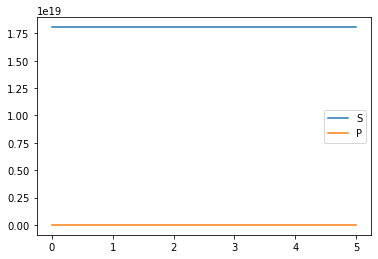

In [146]:
fig,ax = plt.subplots()

ax.plot(timepoints,testcompartment,label = ['S','P'])
ax.legend()

In [147]:
scipy.stats.linregress(timepoints,testcompartment[:,1])

LinregressResult(slope=31.4, intercept=7.3249191103741396e-06, rvalue=1.0, pvalue=0.0, stderr=0.0, intercept_stderr=0.0)

In [ ]:
### Using the model with KmApp and the KmApp/kcat for the encapsulated PhoA mutant I seem to be capturing the same behaviour as shown in the paper

## Have been making strange choices about meaning of KmApp - in the absence of inhibitor (assumed during the experiment) the KmApp = Kmtrue. Inhibitor assumed to be absent due to M-M assumptions
## 

In [179]:
timepoints = np.linspace(0,5,100,dtype='f')

nA = 6.022*10**23


Fv = 1*10**-7
kcat = 31.4  
Km  = 2.45*10**-6 * nA
Ki = 1.74 *10**-6 * nA
k1 = 1.02*10**4
k2 = 6.08*10**2
Kmapp = 2.45*10**-6

Sb0 = 0.5*10**-6 *nA
Sc0 = 0.0
Pc0 = 0.0
Ic0 = 0.0

In [180]:
S0 = Sb0
P0 = Pc0
I0 = Ic0

y0 = [S0,P0,I0]

def nanoreactor_wt_inhibition(y,t):
    S,P,I = y
    dpdt = (kcat*S)/(Km + S + ((Km*I)/Ki))
    dsdt = -(dpdt)
    didt = (dpdt)
    dydt = [dsdt,dpdt,didt]
    return dydt

In [181]:
testcompartment = scipy.integrate.odeint(nanoreactor_wt_inhibition,y0,timepoints)

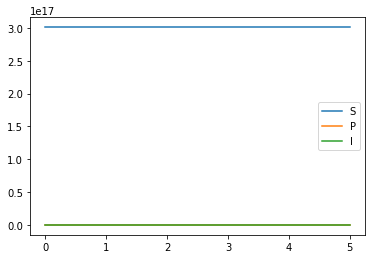

In [182]:
fig,ax = plt.subplots()

ax.plot(timepoints,testcompartment,label = ['S','P','I'])
ax.legend()

In [183]:
scipy.stats.linregress(timepoints,testcompartment[:,1])

LinregressResult(slope=5.322033898305084, intercept=1.2415117094377592e-06, rvalue=1.0, pvalue=0.0, stderr=0.0, intercept_stderr=0.0)

In [184]:
# Constants| nA is avogadros number, Fv volume fraction of capsid, kcat is s^-1, Km is quoted in M and scaled up by nA so units are consitent in model
nA = 6.022*10**23
Fv = 1*10**-7
kcat = 31.4  
Km  = 2.45*10**-6 * nA

In [310]:
k1 = 1.02*10**4
k2 = 1.00
Ki = 1.74 *10**-6 * nA

In [185]:
#Time range| units are in s
timepoints = np.linspace(0,50,1000,dtype='f')

In [187]:
#Concentration range| units are in uM initially, scaled to M
S0range = np.geomspace(0.1,50,num=8,dtype='f') * 10**-6

In [260]:
resultsdict = {}

In [261]:
for concentration in S0range:
    
    S0 = concentration * nA
    P0 = Pc0
    y0 = [S0,P0]
    
    def nanoreactor_wt_kmapp(y,t):
        S,P = y
        dpdt = (kcat*S)/(Km + S)
        dsdt = -(dpdt)

        dydt = [dsdt,dpdt]
        return dydt
    
    conctitle = round(concentration*10**6,2)
    resultsdict[conctitle] = scipy.integrate.odeint(nanoreactor_wt_kmapp,y0,timepoints)

In [262]:
wt_kmapp_timecourse = resultsdict

In [263]:
wt_kmapp_slopes = {}

In [264]:
for key,value in wt_kmapp_timecourse.items():
    wt_kmapp_slopes[key] = scipy.stats.linregress(timepoints,value[:,1]).slope

In [265]:
wt_kmapp_slopes

{0.1: 1.231372562845235,
 0.24: 2.833113435850947,
 0.59: 6.097271691239206,
 1.43: 11.595663610721619,
 3.49: 18.439063624079854,
 8.47: 24.354527626195747,
 20.58: 28.059282201946797,
 50.0: 29.93326974542162}

In [316]:
resultsdict = {}

In [317]:
for concentration in S0range:
    
    S0 = concentration * nA
    P0 = Pc0
    I0 = Ic0
    y0 = [S0,P0,I0]
    
    def nanoreactor_wt_inhibition(y,t):
        S,P,I = y
        dpdt = (kcat*S)/(Km + S + ((Km*I)/Ki))
        dsdt = -(dpdt)
        didt = (dpdt)
        dydt = [dsdt,dpdt,didt]
        return dydt
    
    conctitle = round(concentration*10**6,2)
    resultsdict[conctitle] = scipy.integrate.odeint(nanoreactor_wt_inhibition,y0,timepoints)

In [318]:
wt_inhibition_timecourse = resultsdict
wt_inhibition_slopes = {}
for key,value in wt_inhibition_timecourse.items():
    wt_inhibition_slopes[key] = scipy.stats.linregress(timepoints,value[:,1]).slope

In [319]:
wt_inhibition_slopes ##basically unchanged from above using KmApp - makes sense as according to this model product does not substantially accumulate inhibiting the reaction, so everything looking ok so far

{0.1: 1.2313725628452346,
 0.24: 2.833113435850946,
 0.59: 6.0972716912392,
 1.43: 11.59566361072161,
 3.49: 18.43906362407985,
 8.47: 24.354527626195736,
 20.58: 28.059282201946797,
 50.0: 29.93326974542162}

In [323]:
# wt_inhibition_timecourse[50.0][:,1]

In [489]:
k1 = 1.02*10**6
k2 = 6.08*10**2

In [493]:
resultsdict = {}

In [496]:
##(6/11/23) This is where I confused myself again, gave up, and focused on finishing more experiments.

for concentration in S0range:
    
    S0 = concentration * nA
    Sc0 = Sc0
    P0 = Pc0
    I0 = Ic0
    
    y0 = [S0,Sc0,P0,I0]
    
    def nanoreactor_wt_inhibition(y,t):
        S,Sc,P,I = y
        dsdt = 0
        dscdt = - (1/Fv)*(kcat*Sc)/(Km + Sc + ((Km*I)/Ki)) + (k1*S - k1*Sc)
        dpdt = (kcat*Sc)/(Km + Sc + ((Km*I)/Ki))
        didt = (1/Fv)*(kcat*Sc)/(Km + Sc + ((Km*I)/Ki)) - (k2*I)
       
        
        dydt = [dsdt,dscdt,dpdt,didt]
        return dydt
    
    conctitle = round(concentration*10**6,2)
    resultsdict[conctitle] = scipy.integrate.odeint(nanoreactor_wt_inhibition,y0,timepoints)

TypeError: can't convert expression to float

In [ ]:
wt_transport_timecourse = resultsdict
wt_transport_slopes = {}
for key,value in wt_transport_timecourse.items():
    wt_transport_slopes[key] = scipy.stats.linregress(timepoints,value[:,2]).slope

In [492]:
wt_transport_slopes

{0.1: 1.2313725486746643,
 0.24: 2.8331134041345756,
 0.59: 6.097271627099419,
 1.43: 11.595663503547032,
 3.49: 18.439063489421077,
 8.47: 24.354527502571543,
 20.58: 28.059282114059247,
 50.0: 29.933269692659223}

In [482]:
wt_transport_timecourse[50.0][-10:,2]*(1/Fv)

array([1.48317958e+10, 1.48467770e+10, 1.48617594e+10, 1.48767407e+10,
       1.48917219e+10, 1.49067043e+10, 1.49216856e+10, 1.49366668e+10,
       1.49516492e+10, 1.49666305e+10])

In [483]:
from sympy import *

In [484]:
Fv,kcat,Sc,Km,I,Ki,k1,S,k2 = symbols("F_v k_cat S_c K_m I K^i k^1 S k^2")

In [486]:
- (1/Fv)*(kcat*Sc)/(Km + Sc + ((Km*I)/Ki)) + (k1*S - k1*Sc)

S*k^1 - S_c*k^1 - S_c*k_cat/(F_v*(I*K_m/K^i + K_m + S_c))

In [487]:
(kcat*Sc)/(Km + Sc + ((Km*I)/Ki))

S_c*k_cat/(I*K_m/K^i + K_m + S_c)

In [488]:
(1/Fv)*(kcat*Sc)/(Km + Sc + ((Km*I)/Ki)) - (k2*I)

-I*k^2 + S_c*k_cat/(F_v*(I*K_m/K^i + K_m + S_c))